In [1]:
# DO NOT CHANGE ANYTHING IN THIS BLOCK
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
import tensorflow.keras
import time
import imutils
import hashlib
import pickle

from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import BatchNormalization, Conv2D, MaxPooling2D, AveragePooling2D, Dense, Activation, Dropout, Flatten, Input
from tensorflow.keras.metrics import categorical_accuracy
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import *
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.applications import MobileNetV2
from typing import List
from pathlib import Path
from imutils.video import VideoStream
from PIL import Image

label_map = ['Anger', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

os.chdir('/content/drive/My Drive/Project/EmotionDetection')
print("Currently in directory: ", os.getcwd()) # Check where you are currently working on the google drive
if not os.path.exists('dataset'):
  os.mkdir('dataset') # Create dataset directory under current path

Mounted at /content/drive
Currently in directory:  /content/drive/My Drive/Project/EmotionDetection


Make sure all of your jupyter notebooks and training set are in Google Drive.

## Data Preprocessing

The training and testing images are provided to us as raw values in a csv file column called "pixels" and not as raw image files.

We need to preprocess this data such that the string raw values become a numpy array representing a grayscale image.

Each row of the data file is one image, with corresponding label "emotion", and a "usage" of what the image is to be used for.

In the following section, we will work with the column "pixels" and turn it into numpy arrays that can be used for training the model.

### STEP 1
Load the raw dataset and take a look to understand what we are working with. The file name is `emotions_train_dataset.csv`.
You need to fill in the path to your file.

In [3]:
filepath = 'dataset/emotions_train_dataset.csv'

df = pd.read_csv(filepath, na_filter=False)
df.head()

,emotion,pixels
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


In [4]:
print(df.shape)
display(df.head())

(32298, 2)


,emotion,pixels
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


*emotion* - contains the values 0 - 6, and maps to the labels in *label_map* (in order)

*pixels* - a STRING containing the raw grayscale value to s SQUARE image

#### Question: what do the pixels column look like? What is the data type?

### STEP 2

How many values are in each "pixels" row? Write some code to figure this out!

In [5]:
# your code here
df['pixels'].apply(lambda x: len(x)).describe()


count    32298.000000
mean      8377.755898
std        550.050845
min       4607.000000
25%       8066.000000
50%       8468.000000
75%       8793.000000
max       9215.000000
Name: pixels, dtype: float64

### STEP 3

Write a function to convert each "pixels" string into a numpy array of the correct shape.

In [6]:
'''
implement the function pixels_to_image
it takes in one numpy array and convert it to a 48*48 2D array.
It will also perform the rescale part so that every element in the array is a number between 0 and 1
(hint: we learned this in lab 6)
'''
test_pixels = df.iloc[0, 1]
def pixels_to_image(pixels) -> np.ndarray:
  pixels_lists = [int(n) for n in pixels.split()]
  X = np.array(pixels_lists) / 255
  X = X.reshape(48, 48)
  return X
test_image = pixels_to_image(test_pixels)

In [7]:
# This is for sanity check
test_pixels = df.iloc[0, 1]
test_image = pixels_to_image(test_pixels)

What is the shape the resulting array?

Is it two dimensional or three dimensional?

In [8]:
# your code here
test_image.shape

(48, 48)

In [9]:
'''
implement the function pixels_to_image
it takes in one numpy array and convert it to a 1*48*48*1 4D array.
'''

def pixels_to_image(pixels) -> np.ndarray:
  pixels_lists = [int(n) for n in pixels.split()]
  X = np.array(pixels_lists) / 255
  X = X.reshape(1, 48, 48, 1)
  return X

In [10]:
# sanity check
test_image = pixels_to_image(test_pixels)
test_image.shape

(1, 48, 48, 1)

### STEP 4

Apply your function to the "pixels" data series to obtain a list of numpy image arrays "X"

In [11]:

X = df.pixels.apply(pixels_to_image)

In [12]:

type(X)

pandas.core.series.Series

In [13]:

type(X[0])

numpy.ndarray

In [14]:

X = np.concatenate(X)

In [15]:
# your code here
X.shape

(32298, 48, 48, 1)

In [16]:

Y = df.emotion.astype(int)
# sanity check
print(Y)

0        0
1        0
2        2
3        4
4        6
        ..
32293    4
32294    3
32295    4
32296    4
32297    4
Name: emotion, Length: 32298, dtype: int64


In [17]:

labels = [label_map[e] for e in Y]
# sanity check
print(labels)

['Anger', 'Anger', 'Fear', 'Sad', 'Neutral', 'Fear', 'Sad', 'Happy', 'Happy', 'Fear', 'Anger', 'Neutral', 'Neutral', 'Neutral', 'Happy', 'Surprise', 'Happy', 'Fear', 'Neutral', 'Sad', 'Sad', 'Fear', 'Anger', 'Anger', 'Happy', 'Happy', 'Surprise', 'Anger', 'Happy', 'Surprise', 'Happy', 'Neutral', 'Happy', 'Fear', 'Happy', 'Neutral', 'Neutral', 'Neutral', 'Anger', 'Surprise', 'Anger', 'Happy', 'Sad', 'Anger', 'Neutral', 'Fear', 'Happy', 'Neutral', 'Fear', 'Fear', 'Fear', 'Surprise', 'Surprise', 'Neutral', 'Sad', 'Surprise', 'Anger', 'Happy', 'Sad', 'Fear', 'Neutral', 'Surprise', 'Happy', 'Sad', 'Happy', 'Anger', 'Sad', 'Happy', 'Anger', 'Surprise', 'Sad', 'Fear', 'Sad', 'Fear', 'Anger', 'Neutral', 'Anger', 'Anger', 'Surprise', 'Sad', 'Happy', 'Surprise', 'Happy', 'Neutral', 'Fear', 'Fear', 'Sad', 'Sad', 'Surprise', 'Sad', 'Anger', 'Anger', 'Neutral', 'Anger', 'Neutral', 'Fear', 'Fear', 'Happy', 'Sad', 'Happy', 'Happy', 'Fear', 'Neutral', 'Happy', 'Sad', 'Happy', 'Fear', 'Anger', 'Fear', 

In [18]:

npy_data = 'dataset/numpy_images.npy'
label_data = 'dataset/labels.pkl'

if Path(npy_data).is_file() and Path(label_data).is_file():
    print('Loading from previously processed training data X and labels Y')
    with open(npy_data, 'rb') as f:
        X = np.load(f)
    with open(label_data, 'rb') as f:
        Y = pickle.load(f)
else:
    print('No training numpy array saved previously. Saving variable X to file.')
    with open(npy_data, 'wb') as f:
        np.save(f, X)
    with open(label_data, 'wb') as f:
        pickle.dump(Y, f)

assert X.shape == (32298, 48, 48, 1)
print(f'Validated that X.shape is (32298, 48, 48, 1)')

assert len(Y) == X.shape[0]
print(f'Validated that len(Y) is {len(Y)}')

Loading from previously processed training data X and labels Y
Validated that X.shape is (32298, 48, 48, 1)
Validated that len(Y) is 32298


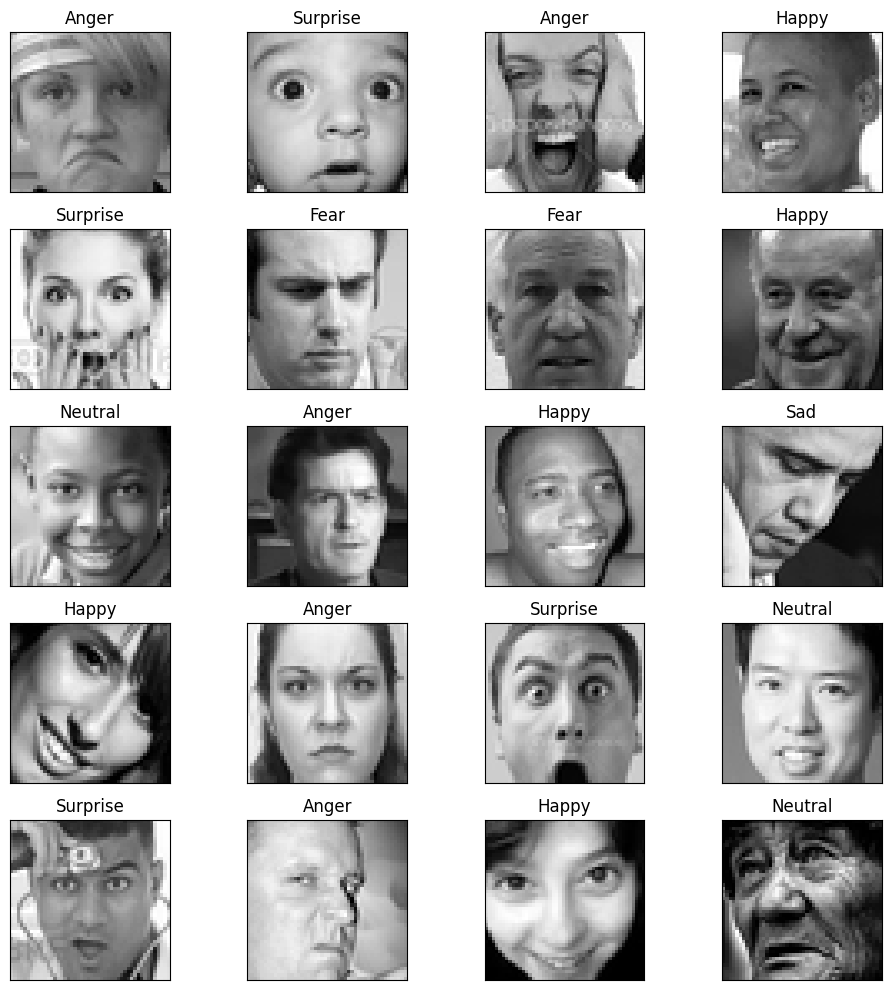

In [19]:
fig = plt.figure(figsize=(10, 10))
columns = 4
rows = 5

for i in range(1, columns*rows +1):
    # Randomly choose an image, img_id should be a random integer going from 0, up to a total number of images in X
    img_id = np.random.choice(X.shape[0])

    # Select the numpy array corresponding to the index that is randomly chosen
    img = X[img_id, :, :, 0]

    fig.add_subplot(rows, columns, i)
    plt.imshow(img, cmap='gray')
    plt.xticks([], [])
    plt.yticks([], [])

    # Add the emotion label for the selected image as the title
    plt.title(labels[img_id])

fig.tight_layout()
plt.show()

In [21]:
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.1, random_state=0)

Check the shape of each of the above variables to make sure they are reasonable

In [22]:

def generate_id(digest_size=4):
    hash = hashlib.blake2b(digest_size=digest_size)
    hash.update(str(time.time()).encode('utf-8'))
    return hash.hexdigest()

In [23]:

def write_array_to_image_files(X, y, resolution, dataset_name):
    arrays = []
    for arr in X[:,:,:,0]:
        arrays.append(np.array(Image.fromarray(arr).resize(size=(resolution, resolution))))
    resized_array = np.array(arrays)
    resized_array = np.expand_dims(resized_array, axis=-1)
    resized_array = np.concatenate([resized_array, resized_array, resized_array], axis=-1)

    # First create the directories that corresponds to the target class name
    for k in set(y):
        dir_path = Path(f'dataset/{dataset_name}/{str(k)}')
        dir_path.mkdir(parents=True, exist_ok=True)

    # Write each image into the target class folder
    # Remember to multiple by 255 as our array data is normalized to 1
    for arr, i in zip(resized_array, y):
        im = Image.fromarray(np.uint8(arr*255))
        im.save(f'dataset/{dataset_name}/{str(i)}/{generate_id()}.jpg')

In [ ]:
for X, y, dataset_name in zip([X_train, X_val], [y_train, y_val], ['train', 'val']):
    write_array_to_image_files(X, y, 224, dataset_name)